In [19]:
import pandas as pd
import nltk
import numpy as np
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import re
import string
from gensim.models import Word2Vec
from nltk import word_tokenize
from nltk.corpus import stopwords

from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

#pip install googletrans==3.1.0a0 что бы заработал !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
import googletrans
from googletrans import Translator

SEED = 100

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sorok\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sorok\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Коротко основная идея.  
#### Работает команда разработчиков, выполняют задачи и каждая задача занимает какое-то количество времени. Есть датафрейм train в котором собраны в том числе описание задачи (может быть на русском и на английском), идентификатор проекта, заказчик задачи, исполнитель задачи и целевая переменная - время выполнения задачи. Кроме того, есть датафрейм с комментариями/перепиской к каждой задаче (есть задачи которые не сопровождались перепиской и по ним нет комментарием) и есть датафрейм который несет в себе описание заказчиков и исполнителей, он больше похож на выписку из отдела кадров. Задача - научится предсказывать время выполнения задачи.  
#### Основная идея/идеи: откинуть выбросы, отобрать значимые признаки из того что есть, обработать текстовые данные, кластеризовать задачи, извлеч что-то полезное из комментариев (удалось, ввести признак количества комментариев по задаче и кластеризовать "суммарные" комментарии)  и сделать предсказание градиентным бустингом. Метрика оценки R2.

In [2]:
train_issues = pd.read_csv('train_issues.csv')
train_comments = pd.read_csv('train_comments.csv')
test_issues = pd.read_csv('test_issues.csv')
test_comments = pd.read_csv('test_comments.csv')
employees = pd.read_csv('employees.csv')
sample_solution = pd.read_csv('sample_solution.csv')

### В текстах есть рускоязычные и англоязычные объекты, в какой-то момент оказалось эффективным сделать перевод с русского на английский и далее работать уже с английскими текстами.  
### Код ниже делает перевод данных на английский и сохраняет его.

In [24]:
#translator = Translator()
#def trans_lator(text):
#    result = translator.translate(text, src='ru', dest='en') 
#    return result.text

#train_issues['summary'] = train_issues['summary'].apply(trans_lator)
#train_issues.to_csv('train_issues_en.csv', index=False)

#test_issues['summary'] = test_issues['summary'].apply(trans_lator)
#test_issues.to_csv('test_issues_en.csv', index=False)

#train_comments['text'] = train_comments['text'].apply(trans_lator)
#train_comments.to_csv('train_comments_en.csv', index=False)

#test_comments['text'] = test_comments['text'].apply(trans_lator)
#test_comments.to_csv('test_comments_en.csv', index=False)


In [3]:
# перевод на английский только описаний дает 0.0997 перевод еще и комментов понижает на чуть чуть результат
train_issues = pd.read_csv('train_issues_en.csv')
test_issues = pd.read_csv('test_issues_en.csv')
#train_comments = pd.read_csv('train_comments_en.csv')
#test_comments = pd.read_csv('test_comments_en.csv')

## Посмотрим на train

In [4]:
print('Записей в train', train_issues.shape[0], ', Записей в test', test_issues.shape[0])
print('Начальная дата train', train_issues['created'].min())
print('Конечная дата train', train_issues['created'].max())
print('Начальная дата test', test_issues['created'].min())
print('Конечная дата test', test_issues['created'].max())
print('project_id в train', train_issues['project_id'].value_counts().count(), ', project_id в test', test_issues['project_id'].value_counts().count())
print('assignee_id в train', train_issues['assignee_id'].value_counts().count(), ', asiignee_id в test', test_issues['assignee_id'].value_counts().count())
print('creator_id в train', train_issues['creator_id'].value_counts().count(), ', creator_id в test', test_issues['creator_id'].value_counts().count())
train_issues.head()

Записей в train 9589 , Записей в test 1070
Начальная дата train 2017-10-05 10:01:14.000
Конечная дата train 2021-02-12 20:44:45.000
Начальная дата test 2020-01-15 09:52:57.000
Конечная дата test 2021-07-23 13:28:04.185
project_id в train 7 , project_id в test 7
assignee_id в train 51 , asiignee_id в test 28
creator_id в train 52 , creator_id в test 27


,id,created,key,summary,project_id,assignee_id,creator_id,overall_worklogs
0,819952,2019-10-01 05:57:18.000,SM-10678,UI tests commissioned by Dobro KG,5,93,93,1800
1,819949,2019-10-01 05:59:45.000,SM-10679,"UI tests of the ""Profile"" section",5,93,93,7200
2,819947,2019-10-01 06:00:38.000,SM-10680,"UI tests of the section ""Personal account""",5,93,93,14400
3,819943,2019-10-01 06:02:49.000,SM-10682,"UI tests of the ""News"" section",5,93,93,900
4,819941,2019-10-01 06:03:26.000,SM-10683,"UI tests of the ""Zones of discounts and surcha...",5,93,93,900


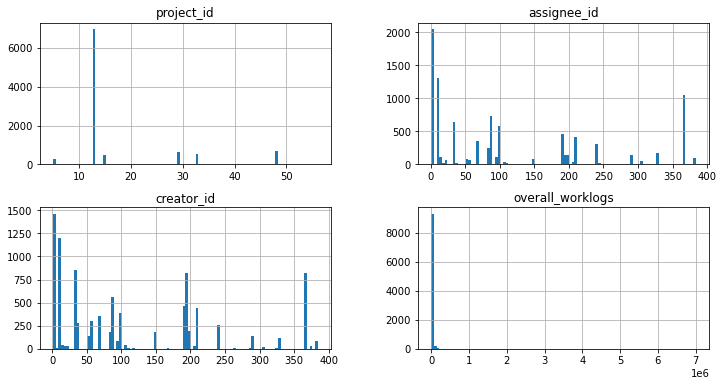

In [5]:
_ = train_issues[['project_id', 'assignee_id', 'creator_id', 'overall_worklogs']].hist(figsize=(12,6), bins = 100)

In [6]:
print('min/mean/max время выполнения', train_issues['overall_worklogs'].min(), '/', round(train_issues['overall_worklogs'].mean()), '/', train_issues['overall_worklogs'].max())
print('Количество записей со значением >50000', train_issues[train_issues['overall_worklogs']>50000].value_counts().count())
print('Количество записей со значением >100000', train_issues[train_issues['overall_worklogs']>100000].value_counts().count())
print('Количество записей со значением <600', train_issues[train_issues['overall_worklogs']<600].value_counts().count())
print('Количество записей со значением <1000', train_issues[train_issues['overall_worklogs']<1000].value_counts().count())

min/mean/max время выполнения 60 / 17244 / 7014000
Количество записей со значением >50000 485
Количество записей со значением >100000 158
Количество записей со значением <600 101
Количество записей со значением <1000 633


### Посмотрим на распределение целевой переменной

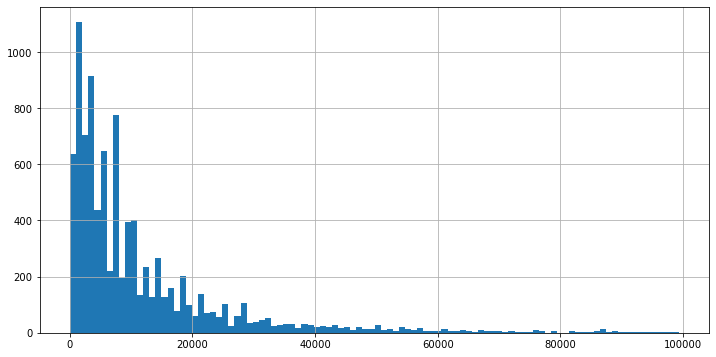

In [7]:
# распределение целевой переменной < 100000
_ = train_issues[train_issues['overall_worklogs']<100000]['overall_worklogs'].hist(figsize=(12,6), bins = 100)

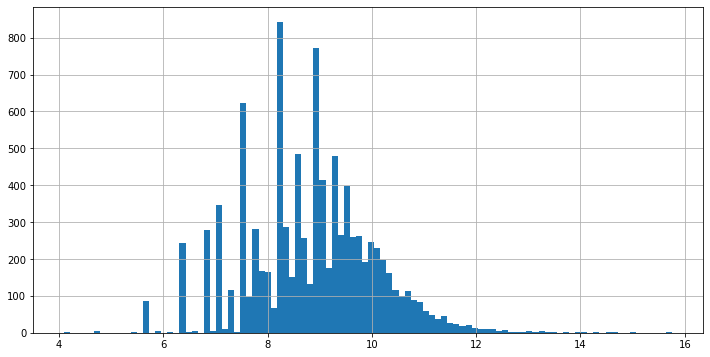

In [8]:
# распределение прологарифмированной целевой переменной по всем значениям
_ = np.log(train_issues[train_issues['overall_worklogs']<1000000000]['overall_worklogs']).hist(figsize=(12,6), bins = 100)

### В процессе исследования оказалось что выбросами можно считать все значения целевой переменной которые меньше 600 и больше 100000.

In [9]:
# откинем выбросы
train_issues = train_issues[(train_issues['overall_worklogs']<100000)&(train_issues['overall_worklogs']>600)]

## Посмотрим на тексты

In [10]:
print('Комментариев в трейне', train_comments.shape[0])
train_comments.head()

Комментариев в трейне 13918


,comment_id,text,issue_id,author_id
0,11779,[https://www.youtube.com/watch?v=tuhOdtsvoNY|h...,669666,1
1,10601,OK [~accountid:557058:3f7ab89a-8969-4547-90df-...,669670,1
2,76101,I encountered a problem with access to `/users...,670930,2
3,76102,I have learned that `users/:id/emails` endpoin...,670930,2
4,76213,We have decided with Andrew to set member's em...,670930,2


In [11]:
print('Комментариев в тесте', test_comments.shape[0])
test_comments.head()

Комментариев в тесте 1348


,comment_id,text,issue_id,author_id
0,76324,I wasted much time building one graph by using...,670929,2
1,75499,почитал статьи по переносу доменов на клаудфей...,675831,112
2,75519,Посмотрел еще раз как переносят сайты на клауд...,675831,112
3,75490,Проверил построчно импортнутые записи в cloudf...,675834,112
4,75442,Хотел найти способ автоматически перенести зап...,675836,112


## Посмотрим на описания заказчиков/исполнителей

In [32]:
employees.head()

,id,active,full_name,position,hiring_type,payment_type,salary_calculation_type,english_level,passport,is_nda_signed,is_labor_contract_signed,is_added_to_internal_chats,is_added_one_to_one
0,1,1,David Courtney,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
1,2,0,Dan Guerra,Web-разработчик,staff,fixed,NaN,NaN,0,0,0,0,0
2,4,0,Grady Smith,Web-разработчик,staff,fixed,NaN,NaN,0,0,0,0,0
3,6,0,James Powell,Разработчик мобильных приложений,staff,fixed,NaN,NaN,0,0,0,0,0
4,8,1,John Brown,Разработчик мобильных приложений,staff,fixed,NaN,NaN,1,1,1,1,1


## Добавим преобразуем данные

In [13]:
# рабочая функция лематизации и приведения текстов
#stop_words = stopwords.words('english') + stopwords.words('russian')
stop_words = stopwords.words('english')
patterns = "0-9[!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+" # "0-9[!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"  вопрос с удалением чисел !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

morph = MorphAnalyzer()

def lemmatize(doc):
    how_many_tokens = 5000 # количсетво первых слов которые будут возвращены
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token and token not in stop_words:
            token = token.strip()
            token = morph.normal_forms(token)[0]
            
            tokens.append(token)
    if len(tokens) >= 2: # условие длинный слова !!!
        return tokens[0:how_many_tokens] #str(' '.join(tokens[0:how_many_tokens]))
    return None


In [14]:

def transform(train_issues, train_comments, employees):
    # Убрали столбец с временем создани задачи
    # Добавили столбец с количеством коментов
    train = train_issues.drop(columns=['created', 'key'], axis=1)
    train['lematize_summary'] = train_issues['summary'].apply(lemmatize).fillna('NotDefined')
    train = pd.merge(train, train_comments.groupby(by='issue_id').count()['text'], left_on="id", right_on="issue_id", how='left').fillna(0)
    train.rename(columns={'text':'comments'}, inplace=True)
    employees_data = employees.drop(columns=['active', 'full_name', 'salary_calculation_type', 'english_level']).fillna('NotDefined')
    mployees_data = employees_data.drop(columns=['is_nda_signed', 'is_labor_contract_signed', 'is_added_one_to_one'], inplace=True)
    # добавим столбец с суммой комментариев
    train = pd.merge(train, train_comments.groupby('issue_id')['text'].apply(lambda x: ' '.join(x)), left_on="id", right_on="issue_id", how='left').fillna('NotDefined')
    train['lematize_comments'] = train['text'].apply(lemmatize).fillna('NotDefined')
    train.drop(columns='text', inplace=True)
    # добавили в train данные исполнителя, заказчика оставили просто как id
    train = pd.merge(train, employees_data.iloc[:,0:], left_on="assignee_id", right_on="id", how='left')
    # удалим лишние столбцы В ТОМ ЧИСЛЕ SUMMARY пока нет NLP модели
    train.drop(columns=['id_y', 'id_x',  'summary', 'assignee_id'], inplace=True)
    return(train)

In [15]:
def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features
 

In [16]:
train_transform = transform(train_issues, train_comments, employees)
test_transform = transform(test_issues, test_comments, employees)

In [19]:
# интересная попытка избавится от криэйторов и исполнителей которых нет в трейне (но есть в тесте)
# не дает результат
#test_assignee_list = test_issues['assignee_id'].value_counts().index
#test_creator_list = test_issues['creator_id'].value_counts().index
#train_issues[(train_issues['assignee_id'].isin(test_assignee_list))&(train_issues['creator_id'].isin(test_creator_list))]

In [17]:
# датафрейм после всех преобразовани1
# comments - количсетво коментариев к задаче
train_transform.head()

,project_id,creator_id,overall_worklogs,lematize_summary,comments,lematize_comments,position,hiring_type,payment_type,passport,is_added_to_internal_chats
0,5,93,1800,"[ui, tests, commissioned, dobro, kg]",0.0,NotDefined,Разработчик мобильных приложений,staff,fixed,1,1
1,5,93,7200,"[ui, tests, ""profile"", section]",1.0,"[приверить, и, принять, mr]",Разработчик мобильных приложений,staff,fixed,1,1
2,5,93,14400,"[ui, tests, section, ""personal, account""]",0.0,NotDefined,Разработчик мобильных приложений,staff,fixed,1,1
3,5,93,900,"[ui, tests, ""news"", section]",0.0,NotDefined,Разработчик мобильных приложений,staff,fixed,1,1
4,5,93,900,"[ui, tests, ""zones, discounts, surcharges"", se...",1.0,"[принять, mr]",Разработчик мобильных приложений,staff,fixed,1,1


In [20]:
#  кластеризуем описания задачи по всем объектам трейн + тест
for_vect = pd.DataFrame(columns=['summary','comments'])
for_vect['summary'] = train_transform['lematize_summary'].append(test_transform['lematize_summary'], ignore_index=True) # длина трейновой части 9589, 0:9589
for_vect['comments'] = train_transform['lematize_comments'].append(test_transform['lematize_comments'], ignore_index=True) # длина трейновой части 9589, 0:9589
model_summary = Word2Vec(sentences=for_vect['summary'], vector_size=100, workers=1, seed=SEED)
model_comments = Word2Vec(sentences=for_vect['comments'], vector_size=1000, workers=1, seed=SEED)
vectorized_summary = vectorize(for_vect['summary'], model=model_summary)
vectorized_comments = vectorize(for_vect['comments'], model=model_comments)

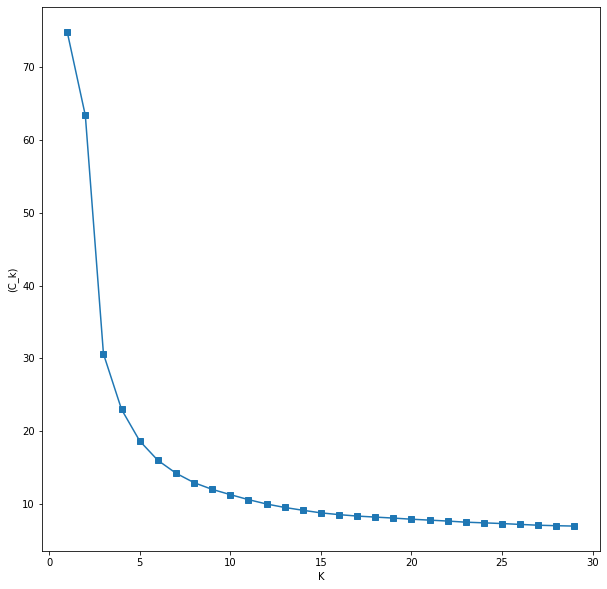

In [21]:
# кластеризация задач
from sklearn.cluster import KMeans
inertia = []
for k in range(1,30,1):
    mbk  = KMeans(n_clusters=k,init='random', random_state=1).fit(vectorized_summary)
    inertia.append(np.sqrt(mbk.inertia_))
plt.figure(figsize=(10, 10))
plt.plot(range(1,30,1),inertia,marker='s')
plt.xlabel('K')
plt.ylabel('(C_k)')
plt.show()

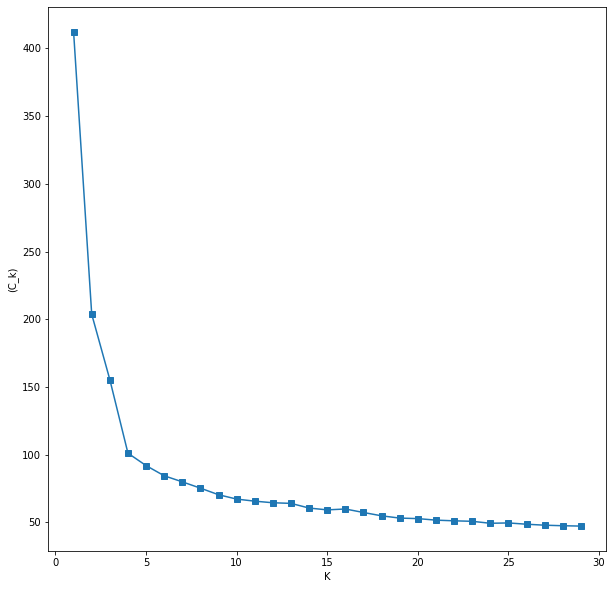

In [22]:
# кластеризация комментов
from sklearn.cluster import KMeans
inertia = []
for k in range(1,30,1):
    mbk  = KMeans(n_clusters=k,init='random', random_state=1).fit(vectorized_comments)
    inertia.append(np.sqrt(mbk.inertia_))
plt.figure(figsize=(10, 10))
plt.plot(range(1,30,1),inertia,marker='s')
plt.xlabel('K')
plt.ylabel('(C_k)')
plt.show()

In [23]:
# добавление столбца с кластерами задач
n_kluster_summary = 8
mbk  = KMeans(n_clusters=n_kluster_summary,init='random').fit(vectorized_summary)
y_kmeansMBK = mbk.predict(vectorized_summary)
Num = [] 
Num = [pt for pt in y_kmeansMBK]
df2 = {"Num_Cluster": Num}
dfMBK = pd.DataFrame(df2)
train_transform['cluster_summary'] = dfMBK.iloc[0:9086, 0]
test_transform['cluster_summary'] = dfMBK.iloc[9086:, 0].reset_index(drop=True)

In [24]:
# добавление столбца с кластерами комментов
n_kluster_comments = 6
mbk  = KMeans(n_clusters=n_kluster_comments,init='random').fit(vectorized_comments)
y_kmeansMBK = mbk.predict(vectorized_comments)
Num = [] 
Num = [pt for pt in y_kmeansMBK]
df2 = {"Num_Cluster": Num}
dfMBK = pd.DataFrame(df2)
train_transform['cluster_comments'] = dfMBK.iloc[0:9086, 0]
test_transform['cluster_comments'] = dfMBK.iloc[9086:, 0].reset_index(drop=True)


In [25]:

train_transform.drop(columns=['lematize_summary', 'lematize_comments'], inplace=True)
test_transform.drop(columns=['lematize_summary', 'lematize_comments'], inplace=True)

In [47]:
# избавимся от криэйторов и исполнителей которых нет в трейне (но есть в тесте)
#test_assignee_list = test_issues['assignee_id'].value_counts().index
#test_creator_list = test_issues['creator_id'].value_counts().index
#train_transform = train_transform[(train_issues['assignee_id'].isin(test_assignee_list))&(train_issues['creator_id'].isin(test_creator_list))]

In [26]:
X = train_transform.drop(columns=['overall_worklogs'])
y = train_transform['overall_worklogs']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [27]:
from catboost import CatBoostRegressor
cat = CatBoostRegressor(iterations=1000)
cat.fit(X_train,y_train,verbose=False, plot=True, cat_features=['project_id','creator_id',
'position','hiring_type','payment_type','passport','is_added_to_internal_chats', 'cluster_summary', 'cluster_comments'])

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [31]:
expected_y  = y_test
predicted_y = cat.predict(X_test)
predicted_y = [600 if x<600 else x for x in predicted_y]
predicted_y = list(map(lambda x: x-x % -100, predicted_y))
print('R2 = ',r2_score(expected_y, predicted_y ))


R2 =  0.12532557350179596
